In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr

import json

rng = np.random.default_rng(42)

## Un deuxième regard : effets du substrat, échantillonnage par région, données additionnelles, prévisions

_doc version: 1, doc type: submission, doc title: A second look, author: Roger Erismann, roger@hammerdirt.ch_

Dans le premier modèle, les données ont été regroupées par canton. Cependant, il existe deux variables indépendantes qui peuvent améliorer la performance du modèle (ou expliquer la variabilité):

1. Le substrat du lieu d'échantillonnage a été noté de 1 à 4 par les chercheurs.
2. Hydrologie: le lac a été historiquement divisé en trois régions. Ces régions représentent des profils hydrologiques différents.

### Résumé

Le nombre d'échantillons incluant les mises à jour est de 136. Le total moyen des échantillons est de 126pcs, la médiane est de 96pcs. Il y a 25 emplacements différents. La valeur moyenne la plus élevée est 419pcs (Grangettes) et la plus basse est 19pcs (Crans).

#### Régions

Le Grand lac a le nombre d'échantillons (82), la moyenne (140pcs) et la médiane (122pcs) les plus élevés. La moyenne au Haut lac est de 128pcs pour 28 échantillons,  soit à peu près la même chose que le Grand lac. Par contre la médiane est supérieure de 50pcs dans le Grand lac, ce qui indique que les résultats dans le Haut lac sont les résultats sont plus étalése par rapport au Grand lac. Une autre façon de voir les choses est que des résultats élevées sont tout aussi probables dans le Haut Lac que dans le Grand Lac malgré les différences dans la statistique sommaire. La Petit lac a la médiane et la moyenne les plus basses. Cependant, la médiane est de 71pcs, soit seulement deux pcs de moins que le Haut lac (73pcs). Cela indique que les résultats élevées sont moins fréquentes dans le Petit lac.

#### Substrat

Il y a quatre catégories de substrat:

1. Sable fin
2. Sable grossier
3. Gravier
4. Galet

**Sable fin:** 51 échantillons, 32 du Grand Lac, 11 du Haut lac et 8 du Petit lac. Le Haut lac a le résultat moyen le plus élevé (210pcs), mais la médiane la plus élevée est le Grand lac (129pcs).  Ce substrat a également la valeur moyenne la plus élevée pour tous les types de matériaux, (toutes régions et tous lieux confondus).

**Sable grossier:** 34 échantillons, 26 du Grand Lac, 7 du Haut lac et 1 du Petit lac. Le Grand lac a le résultat moyen le plus élevé (140pcs) ainsi que la médiane (122pcs). Les résultats dans ce substrat sont moins importants que substrats 1 et 3 mais comparable celle du substrat 4. 

**Gravier:** 18 échantillons, 1 du Grand Lac, 3 du Haut lac et 14 du Petit lac. Le Grand lac a le résultat moyen le plus élevé (128pcs) ainsi que la médiane (128pcs) mais avec un échantillon seulment. Ce substrat contient plus d'échantillons de Petit lac que des autres régions. La moyenne = la médiane pour le Petit lac dans ce substrat. Cela peut être significatif car trois endroits différents sont représentés dans les 14 échantillons. Cela confirme également l'observation selon laquelle les valeurs extrêmes sont moins probables dans le Petit lac par rapport au Haut lac et au Grand lac.

**Galet:** 33 échantillons, 23 du Grand Lac, 7 du Haut lac et 3 du Petit lac. Le Petit lac a le résultat moyen le plus élevé (130pcs) ainsi que la médiane (120pcs). On note également les plus faibles valeurs moyennes et médianes enregistrées pour le Grand lac dans ce substrat.



#### Previsions et données additionnelles

À l'exception de trois échantillons, toutes les données mises à jour se situent dans l'intervalle de densité la plus élevée (IDH) de 96 % prédit par le modèle dans le *premier regard*. Les trois échantillons suggèrent que les résultats élevés pour les fragments (pas les fibres) sont plus probables que ce que la première série d'échantillons suggère.

**Table des matières**

1. [Résultats par site](section-one)
   1. [Tables](section-oneAB)
      1. Table: Moyenne par événemet
      2. Table: Moyenne par site
2. [Moyen par événement par région](section-two)
   1. Table: [Moyenne par région et par événement](section-twoA)
   2. [Fonction de répartition](section-twoB)
3. [Nombre trouvé par substrat](section-three)
   1. Table: [nombres déchantillons, moyen par matériel](section-threeA)
   2. [Fonction de répartition](section-threeB)
   3. [Distribution par région](section-threeC)
   4. [Resultats par région](section-threeD)
4. [Previsions et données additionnelles](section-four)


In [2]:
# survey results
# this is the initial data set, used to make the predictive model
cprior = pd.read_csv("data/workDataOne.csv")
# these are additions to the data set
new_data = pd.read_csv("data/newmicrodata.csv", header=0)

cprior = cprior.fillna(0)
new_data = new_data.fillna(0)

# posterior predictive results from last itteration
with open("data/fibersGePosteriorPredictive.json", "r") as afile:
    bi = json.load(afile)
with open("data/fragmentsGePosteriorPredictive.json", "r") as afile:
    ai = json.load(afile)
with open("data/totalGePosteriorPredictive.json", "r") as afile:
    totalPosterior = json.load(afile)    
with open("data/fibersVdPosteriorPredictive.json", "r") as afile:
    di = json.load(afile)
with open("data/fragmentsVdPosteriorPredictive.json", "r") as afile:
    ci = json.load(afile)
with open("data/totalVdPosteriorPredictive.json", "r") as afile:
    totalPosteriorvd = json.load(afile)

# sample location and lake region
regions = {
    'Hermance':"petit-lac",
    'Savonière': "petit-lac",
    'Baby Plage': "petit-lac",
    'Versoix': "petit-lac",
    'Crans':"petit-lac",
    'Gland':"grand-lac",
    'Rolle':"grand-lac",
    'Aubonne':"grand-lac",
    'Tolochenaz':"grand-lac",
    'Préverenges':"grand-lac",
    'Vidy':"grand-lac", 
    'Lutry':"grand-lac",
    'Cully':"grand-lac",
    'Pichette':"haut-lac",
    'Clarens': "haut-lac",
    'Grangettes':"haut-lac",
    'Bouveret':"haut-lac",
    'Tougues': "haut-lac",
    'Excenevex':"grand-lac",
    'Meillerie':"haut-lac",
    'Lugrin':"haut-lac",
    'Amphion':"grand-lac",
    'Anthy':"grand-lac",
    'Port Choiseul':"petit-lac",
    'Saint-Disdille':"grand-lac"   
}

# column groups by material type
fibres = ['fr', 'fb', 'fj', 'fw', 'fn', 'fa']
fdure = ['fdr', 'fdb', 'fdj', 'fdw', 'fdn', 'fda']
souple = ['fsr', 'fsb', 'fsj', 'fsw', 'fsn', 'fsa']
fragments = [*fdure, *souple]

# labels for column values
name_the_zones = {1:"ligne-d'eau", 2:"plage-seche"}
m_labels = {1: "Sables fin", 2:"Sables grossiers", 3:"Graviers", 4:"Galets"}

def clean_data(data):
    d = []
    for c in data:
        c["added"] = c[[*fibres, *fdure, *souple]].sum(axis=1)
        c["fibres"] = c[fibres].sum(axis=1)
        c["fdure"] = c[fdure].sum(axis=1)
        c["souple"] = c[souple].sum(axis=1)
        c["fragments"] = c[fragments].sum(axis=1)
        c["z"] =c["z"].map(lambda x: name_the_zones[x])
        
        # the samples where at least one particle was recorded
        cInventoryComplete = c[(c.added > 0) & (c.z == "ligne-d'eau")].copy()        
        cA = cInventoryComplete[["p", "E", "z", "m", "fibres", "fdure", "souple", "fragments"]].copy()
        d.append(cA)
    return d

# new data
newData = clean_data([new_data])[0]
# prior data
cAdded = cprior[["p", "E", "z", "m", "fibres", "fdure", "souple", "fragments"]].copy()

# remove any records from the prior data that may be in the new data
newData = newData[~ newData.E.isin(cAdded.E.unique())].copy()
# label the prior and update data
cAdded["status"] = "prior"
newData["status"] = "update"

# combine the prior and update to one data set
comWorkData = pd.concat([cAdded, newData])
comWorkData.drop_duplicates(inplace=True)
comWorkData.to_csv("data/workDataTwo.csv", index=False)

# work columns
id_vars = ["p", "E", "z", "m"]
value_vars = ["fibres", "fdure", "souple"]
columns={"p":"place", "E":"événement", "z":"zone", "m":"substrat", "value":"y", "variable":"matériel"}

# new data in long form
cwd = pd.melt(comWorkData, id_vars=id_vars, value_vars=value_vars)
cwd.rename(columns=columns, inplace=True)
cwd["région"] = cwd.place.map(lambda x: regions[x])
cwd["substrat"] = cwd.substrat.map(lambda x: m_labels[x])

# charts, labels, colors
region_palette = {"grand-lac":"sandybrown", "petit-lac":"lightseagreen", "haut-lac":"cadetblue"}
m_palette = {"Sables fin":"darkgoldenrod","Sables grossiers":"lightseagreen", "Graviers":"magenta", "Galets":"dodgerblue"}
sns.set_style("whitegrid")

(section-one)=
### 1. Comptage moyen par événement par plage sur *ligne-d'eau*

#### Toutes variantes confondues, toutes les données 

Le nombre moyen de fragments pour chaque événement variait de 19 (Crans) à 420 (Grangettes) par échantillon de 5 X 10 X 10 cm. Les événements pour lesquels aucun compte n'a été rapporté ont été retirés de ce test.

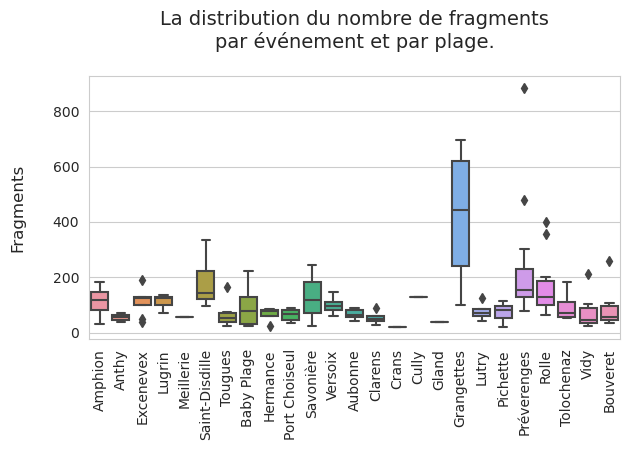

In [3]:
# total per event by place
a_df= cwd.groupby(["événement", "place"], as_index=False)["y"].sum()

fig, ax = plt.subplots()

sns.boxplot(data=a_df, x="place", y="y", hue="place", width=.8, ax=ax, dodge=False)
ax.tick_params(axis="x", which="both", labelrotation=90)
ax.set_ylabel("Fragments", fontsize=12, labelpad=20)
ax.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=6).remove()
ax.set_title("La distribution du nombre de fragments\npar événement et par plage.", fontsize=14, pad=20)
ax.set_xlabel(" ")
ax.margins(x=.9, y=None)

plt.tight_layout()
plt.show()

(section-oneAB)=
#### Résultats par événement

In [4]:
f = f"""
Le nombre moyen de particules par événement tous les sites et matériaux

NOTE: mean = moyen, count=nombre d'événements, std=écart type

{a_df.y.describe()} 

"""
print(f)


Le nombre moyen de particules par événement tous les sites et matériaux

NOTE: mean = moyen, count=nombre d'événements, std=écart type

count    136.000000
mean     126.566176
std      120.694392
min       19.000000
25%       57.000000
50%       96.500000
75%      143.000000
max      884.000000
Name: y, dtype: float64 




In [5]:
f = f""" 
Le nombre moyen de particules par événement

{a_df.groupby("place").y.mean()} 

"""
print(f)

 
Le nombre moyen de particules par événement

place
Amphion           111.500000
Anthy              55.333333
Aubonne            66.833333
Baby Plage         90.875000
Bouveret           90.857143
Clarens            54.250000
Crans              19.000000
Cully             128.000000
Excenevex         113.250000
Gland              40.000000
Grangettes        419.750000
Hermance           66.500000
Lugrin            111.000000
Lutry              77.000000
Meillerie          57.000000
Pichette           72.000000
Port Choiseul      64.000000
Préverenges       218.277778
Rolle             153.761905
Saint-Disdille    179.833333
Savonière         130.000000
Tolochenaz         95.750000
Tougues            67.666667
Versoix            99.750000
Vidy               78.166667
Name: y, dtype: float64 




(section-two)=
### 2. Comptage moyen par événement par région sur *ligne-d'eau*

#### Toutes variantes confondues, toutes les données 

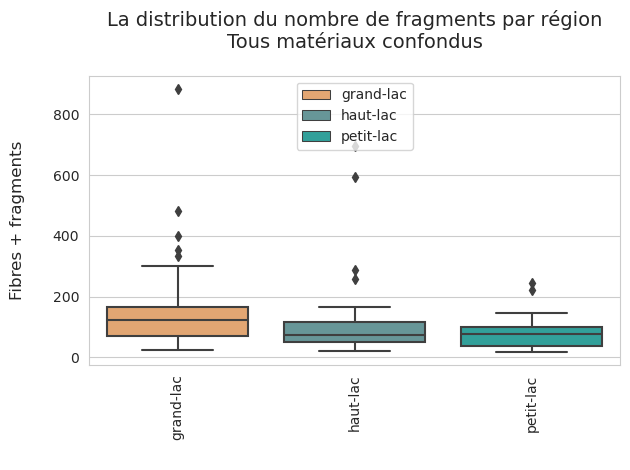

In [6]:
a_df = cwd.groupby(["région","événement"], as_index=False)["y"].sum()

fig, ax = plt.subplots()

sns.boxplot(data=a_df, x="région", y="y", hue="région", palette=region_palette, dodge=False, width=0.8, ax=ax )
ax.tick_params(axis="x", which="both", labelrotation=90)
ax.set_ylabel("Fibres + fragments", fontsize=12, labelpad=20)
ax.legend(loc="upper center")
ax.set_title("La distribution du nombre de fragments par région\nTous matériaux confondus", fontsize=14, pad=20)
ax.set_xlabel(" ")
ax.margins(x=.9, y=None)
plt.tight_layout()
plt.show()

(section-twoA)=
#### Résultats par région

In [7]:
pme = cwd.groupby(["région", "événement"], as_index=False).y.sum()

f = f"""

NOTE: mean = moyen, count=nombre d'événements, std=écart type

Fragments par événement 'haut-lac':

{pme[pme['région'] == "haut-lac"].y.describe()}

Fragments par événement 'grand-lac':

{pme[pme['région'] == "grand-lac"].y.describe()}

Fragments par événement 'petit-lac':

{pme[pme['région'] == "petit-lac"].y.describe()}

"""
print(f)



NOTE: mean = moyen, count=nombre d'événements, std=écart type

Fragments par événement 'haut-lac':

count     28.000000
mean     126.571429
std      160.477165
min       20.000000
25%       50.500000
50%       73.000000
75%      116.250000
max      697.000000
Name: y, dtype: float64

Fragments par événement 'grand-lac':

count     82.000000
mean     140.048780
std      117.968075
min       26.000000
25%       71.250000
50%      122.000000
75%      167.500000
max      884.000000
Name: y, dtype: float64

Fragments par événement 'petit-lac':

count     26.000000
mean      84.038462
std       57.296060
min       19.000000
25%       37.000000
50%       77.500000
75%      100.750000
max      244.000000
Name: y, dtype: float64




(section-twoB)=
### La fonction de répartition par région

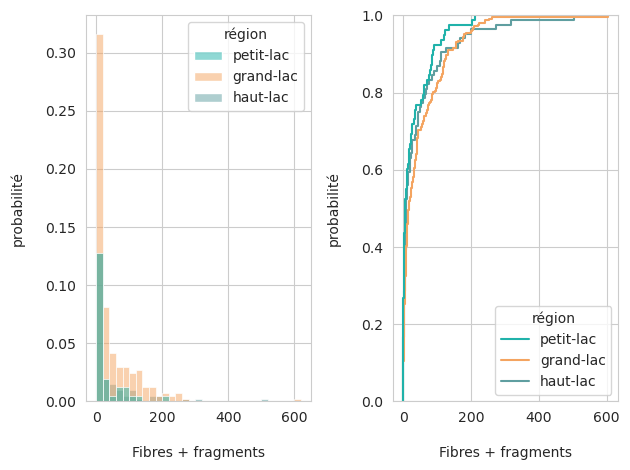

In [8]:
fig, axs = plt.subplots(1,2, sharey=False)

sns.ecdfplot(data=cwd, x="y",  ax=axs[1], hue="région", palette=region_palette)
sns.histplot(data=cwd, x="y",  ax=axs[0], hue="région", stat="probability", binwidth=20, multiple="layer", palette=region_palette)
axs[0].set_ylabel("probabilité", labelpad=15)
axs[1].set_ylabel("probabilité", labelpad=15)
axs[0].set_xlabel("Fibres + fragments", labelpad=15)
axs[1].set_xlabel("Fibres + fragments", labelpad=15)
plt.tight_layout()
plt.show()

(section-three)=
### 3. Nombre trouvé par rapport au substrat

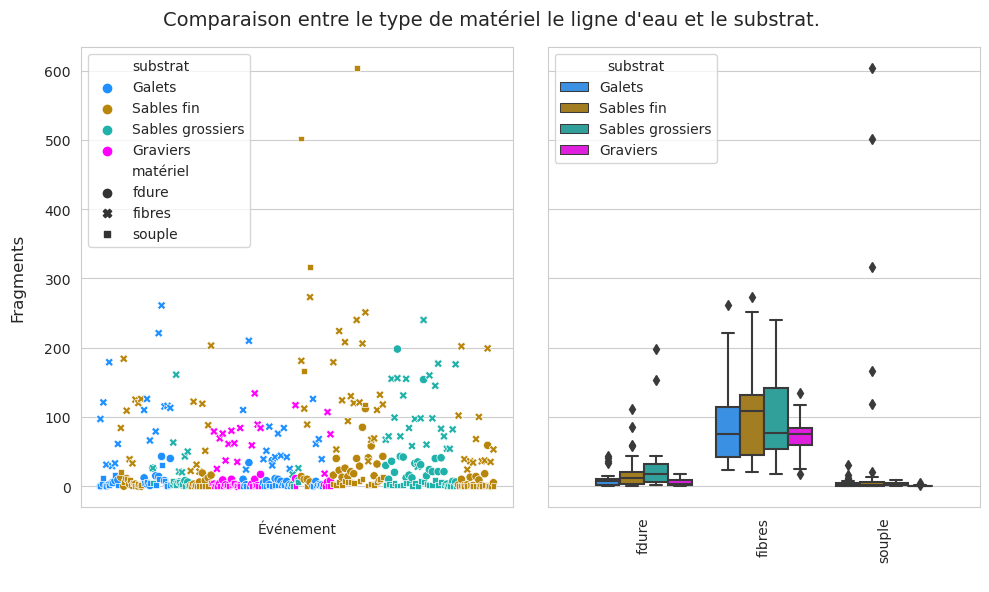

In [9]:
a_df= cwd.groupby(["événement","substrat", "matériel"], as_index=False)["y"].sum()

fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)
ax = sns.scatterplot(data=a_df, x="événement", y="y", hue="substrat", palette=m_palette, ax=axs[0], style="matériel")
ax.xaxis.set_ticklabels([])
ax.grid(axis='x')
ax.set_xlabel("Événement")
ax.set_ylabel("Fragments", fontsize=12, labelpad=14)
ax.legend(loc="upper left")

axOne = axs[1]
sns.boxplot(data=a_df, x="matériel", y="y", hue="substrat", palette=m_palette, width=.8, ax=axOne, dodge=True)

axOne.tick_params(axis="x", which="both", labelrotation=90)
axOne.set_ylabel(" ")
axOne.set_xlabel(" ")
axOne.margins(x=.9, y=None)

plt.suptitle("Comparaison entre le type de matériel le ligne d'eau et le substrat. ", fontsize=14, y=.98)
plt.tight_layout()

plt.show()

(section-threeA)=
#### Nombre d'échantillons par substrat et moyen par matériel

In [10]:
f = f""" 
Le nombre d'échantillons par substrat

{cwd.groupby(["substrat"])["événement"].nunique()}

"""
print(f)

 
Le nombre d'échantillons par substrat

substrat
Galets              33
Graviers            18
Sables fin          51
Sables grossiers    34
Name: événement, dtype: int64




In [11]:
f = f""" 
Le nombre moyen de particules par substrat et matériel

{cwd.groupby(["substrat","matériel"]).y.mean()}

"""
print(f)

 
Le nombre moyen de particules par substrat et matériel

substrat          matériel
Galets            fdure         9.484848
                  fibres       88.333333
                  souple        3.393939
Graviers          fdure         5.111111
                  fibres       71.722222
                  souple        0.555556
Sables fin        fdure        17.784314
                  fibres      109.392157
                  souple       36.470588
Sables grossiers  fdure        27.529412
                  fibres       91.176471
                  souple        2.882353
Name: y, dtype: float64




(section-threeB)=
### La fonction de répartition par substrat

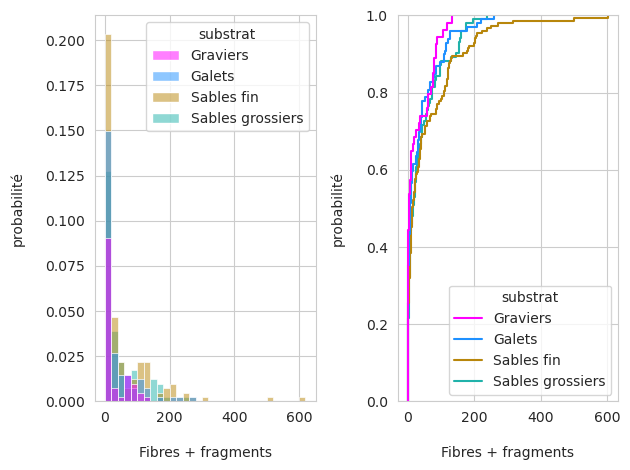

In [12]:
fig, axs = plt.subplots(1,2, sharey=False)


sns.ecdfplot(data=cwd, x="y",  ax=axs[1], hue="substrat", palette=m_palette)
sns.histplot(data=cwd, x="y",  ax=axs[0], hue="substrat", palette=m_palette, stat="probability", binwidth=20, multiple="layer")
axs[0].set_ylabel("probabilité", labelpad=15)
axs[1].set_ylabel("probabilité", labelpad=15)
axs[0].set_xlabel("Fibres + fragments", labelpad=15)
axs[1].set_xlabel("Fibres + fragments", labelpad=15)
plt.tight_layout()
plt.show()

(section-threeC)=
#### Substrat et région

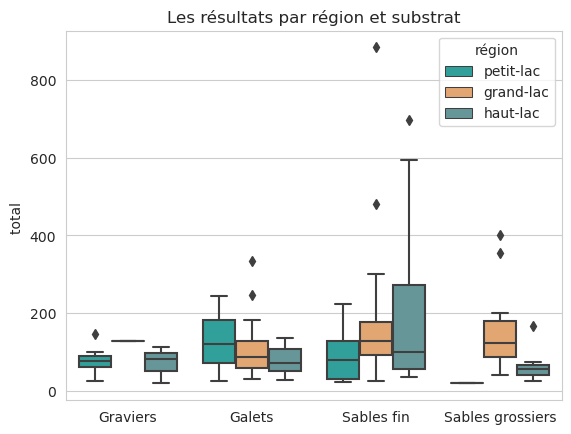

In [13]:
comWorkData["région"] = comWorkData.p.map(lambda x: regions[x])
comWorkData["total"] = comWorkData.fibres + comWorkData.fragments
comstd = comWorkData.total.std()
commean = comWorkData.total.mean()
comWorkData["total scaled"] = (comWorkData.total - commean)/comstd


cDataT = comWorkData.copy()

cDataT = cDataT[["m", "région", "E", "fibres", "fragments", "total"]].copy()
cDataT["m"] = cDataT.m.map(lambda x: m_labels[x])

cMelted = pd.melt(cDataT, id_vars=["m", "E", "région"], value_vars=["total"])
cMelted.reset_index(inplace=True, drop=True)

fig, ax = plt.subplots()

sns.boxplot(data=cMelted, x="m", y="value", hue="région", palette=region_palette, ax=ax, showfliers=True)
ax.set_title("Les résultats par région et substrat")
ax.set_ylabel("total ")
ax.set_xlabel("")
plt.show()

(section-threeD)=
#### Résultats par région

In [14]:
substratRegion = cwd.groupby(["substrat", "région", "événement"], as_index=False).y.sum()
pme = substratRegion.groupby(["substrat", "région"]).agg({"y":["mean", "median", "std"]})

f = f""" 
La Moyen, médian et écart-type par substrat et région

{pme}

"""
print(f)

 
La Moyen, médian et écart-type par substrat et région

                                     y                   
                                  mean median         std
substrat         région                                  
Galets           grand-lac  104.347826   87.0   71.787318
                 haut-lac    78.571429   72.0   40.467506
                 petit-lac  130.000000  120.0  109.343495
Graviers         grand-lac  128.000000  128.0         NaN
                 haut-lac    72.000000   83.0   47.465777
                 petit-lac   74.928571   77.5   30.332679
Sables fin       grand-lac  165.750000  129.0  158.974739
                 haut-lac   210.454545   99.0  232.325790
                 petit-lac   90.875000   79.5   69.790375
Sables grossiers grand-lac  140.461538  122.5   84.804354
                 haut-lac    66.142857   57.0   46.941199
                 petit-lac   19.000000   19.0         NaN




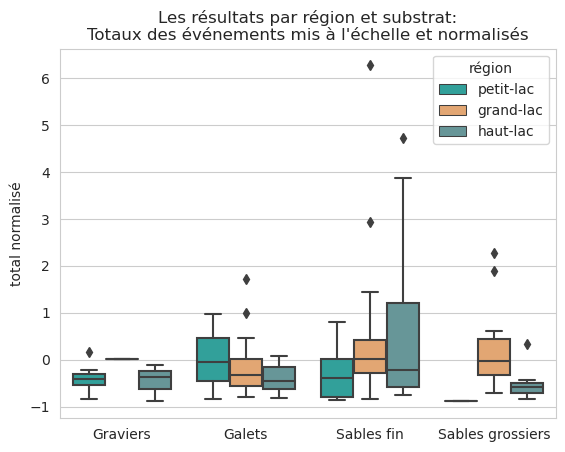

In [15]:
cDataT = comWorkData.copy()

cDataT = cDataT[["m", "région", "E", "fibres", "fragments", "total", "total scaled"]].copy()
cDataT["m"] = cDataT.m.map(lambda x: m_labels[x])

cMelted = pd.melt(cDataT, id_vars=["m", "E", "région"], value_vars=["total scaled"])
cMelted.reset_index(inplace=True, drop=True)

fig, ax = plt.subplots()

sns.boxplot(data=cMelted, x="m", y="value", hue="région", palette=region_palette, ax=ax, showfliers=True)
ax.set_title("Les résultats par région et substrat:\nTotaux des événements mis à l'échelle et normalisés")
ax.set_ylabel("total normalisé")
ax.set_xlabel("")
plt.show()

### Le nombre d'echantillons par région et substrat et plage

In [16]:
pme = cwd.groupby(["région", "substrat", "place"])["événement"].nunique()

f = f""" 
Le nombre d'echantillons par région et substrat et plage

{pme}

"""
print(f)

 
Le nombre d'echantillons par région et substrat et plage

région     substrat          place         
grand-lac  Galets            Amphion            4
                             Anthy              3
                             Aubonne            6
                             Lutry              4
                             Saint-Disdille     6
           Graviers          Cully              1
           Sables fin        Excenevex          8
                             Préverenges       18
                             Vidy               6
           Sables grossiers  Gland              1
                             Rolle             21
                             Tolochenaz         4
haut-lac   Galets            Clarens            4
                             Lugrin             3
           Graviers          Pichette           3
           Sables fin        Bouveret           7
                             Grangettes         4
           Sables grossiers  Meillerie        

(section-four)=
### 4. Modèle linéaire généralisé (MLG/GLM) 

Le modèle développé avec le premier ensemble de données (*prior*) a été utilisé pour prédire les valeurs possibles (*posterior predictive*) pour les données futures (*update*).

La mise à jour est concentrée avec les prieurs et la masse des valeurs prédites. Cependant, trois échantillons suggèrent que les résultats > 200 pour les fragments (durs + souples) peuvent être plus fréquents que ce qui était supposé auparavant.

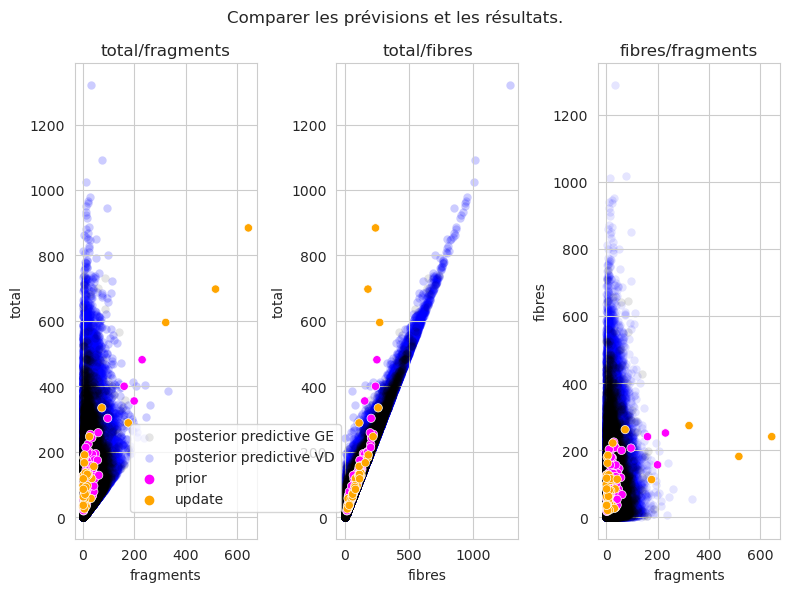

In [17]:
update_palette = {"prior":"magenta", "update":"orange"}
fig, axs = plt.subplots(1, 3, sharey=False, figsize=(8,6))
cData = comWorkData.copy()

ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

sns.scatterplot(x=bi, y=totalPosterior, label="posterior predictive GE", c="black", linewidth=0, alpha=0.1,ax=ax2, zorder=1)
sns.scatterplot(x=ai, y=totalPosterior, c="black", linewidth=0, alpha=0.1, ax=ax1, zorder=1)
sns.scatterplot(x=ai, y=bi,  c="black", linewidth=0, alpha=0.1, ax=ax3, zorder=1)

sns.scatterplot(x=di, y=totalPosteriorvd, label="posterior predictive VD", c="blue", linewidth=0, alpha=0.2,ax=ax2, zorder=0)
sns.scatterplot(x=ci, y=totalPosteriorvd, c="blue", linewidth=0, alpha=0.2, ax=ax1, zorder=0)
sns.scatterplot(x=ci, y=di,  c="blue", linewidth=0, alpha=0.1, ax=ax3, zorder=0)

sns.scatterplot(data=comWorkData, x="fibres", y="total",  hue="status", palette=update_palette, ax=ax2, zorder=3)
sns.scatterplot(data=comWorkData, x="fragments", y="total", hue="status", palette=update_palette, ax=ax1, zorder=3)
sns.scatterplot(data=comWorkData, x="fragments", y="fibres",  hue="status", palette=update_palette,ax=ax3, zorder=3)

ax1.set_title("total/fragments")
ax2.set_title("total/fibres")
ax3.set_title("fibres/fragments")

h, l = ax2.get_legend_handles_labels()
ax2.get_legend().remove()
ax1.get_legend().remove()
ax3.get_legend().remove()

plt.suptitle("Comparer les prévisions et les résultats.")
fig.legend(h, l, bbox_to_anchor=(.16, .3), loc="upper left")
plt.tight_layout()

plt.show()